CT Reconstruction (ADMM Plug-and-Play Priors w/ BM3D, SVMBIR+CG)
================================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.html#scico.optimize.ADMM) to
solve a tomographic reconstruction problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

This version uses the data fidelity term as the ADMM f, and thus the
optimization with respect to the data fidelity uses CG rather than the
prox of the SVMBIRWeightedSquaredL2Loss functional.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.radon_svmbir import ParallelBeamProjector, SVMBIRWeightedSquaredL2Loss
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = ParallelBeamProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up an ADMM solver.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

ρ = 15  # ADMM penalty parameter
σ = density * 0.18  # denoiser sigma

f = SVMBIRWeightedSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g0 = σ * ρ * BM3D()
g1 = NonNegativeIndicator()

solver = ADMM(
    f=f,
    g_list=[g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 100}),
    itstat_options={"display": True, "period": 1},
)

Run the solver.

In [7]:
print(f"Solving on {device_info()}\n")
x_bm3d = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  1.21e+01  4.115e-01  3.176e-01     15  9.480e-05


   1  2.41e+01  1.807e-01  2.358e-01     14  7.318e-05


   2  3.43e+01  8.677e-02  1.455e-01     12  8.535e-05


   3  4.35e+01  7.186e-02  8.425e-02     11  8.726e-05


   4  5.31e+01  6.293e-02  5.028e-02     10  7.366e-05


   5  6.04e+01  4.470e-02  4.256e-02      8  9.395e-05


   6  6.78e+01  3.053e-02  3.732e-02      8  7.135e-05


   7  7.54e+01  2.598e-02  2.920e-02      7  6.585e-05


   8  8.14e+01  2.331e-02  2.160e-02      6  9.335e-05


   9  8.77e+01  2.057e-02  1.854e-02      6  8.086e-05


  10  9.39e+01  1.785e-02  1.613e-02      6  8.865e-05


  11  1.00e+02  1.647e-02  1.466e-02      6  7.683e-05


  12  1.06e+02  1.538e-02  1.320e-02      5  8.891e-05


  13  1.11e+02  1.440e-02  1.197e-02      5  8.980e-05


  14  1.17e+02  1.377e-02  1.166e-02      4  9.782e-05


  15  1.22e+02  1.346e-02  1.204e-02      4  9.021e-05


  16  1.26e+02  1.291e-02  1.232e-02      3  9.348e-05


  17  1.32e+02  1.247e-02  1.283e-02      5  8.382e-05


  18  1.37e+02  1.193e-02  1.151e-02      5  9.328e-05


  19  1.42e+02  1.129e-02  1.107e-02      4  8.411e-05


Show the recovered image.

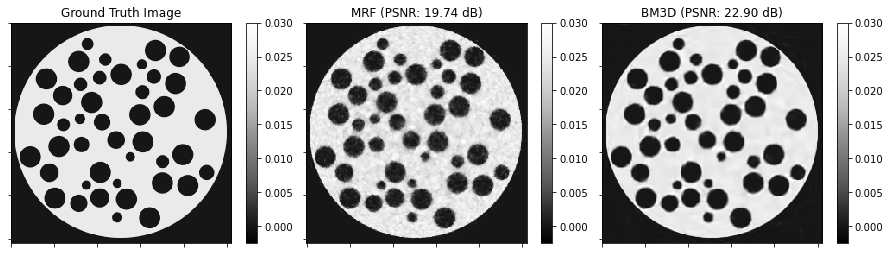

In [8]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_bm3d,
    title=f"BM3D (PSNR: {metric.psnr(x_gt, x_bm3d):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

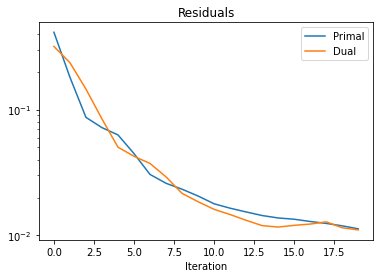

In [9]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)